# Анализ пользовательского поведения в мобильном приложении

# Описание данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import numpy as np
import seaborn as sns
from scipy import stats as st
import math as mth

<a id='Изучение общей информации'></a>
## Изучение общей информации

In [2]:
df = pd.read_csv('logs_exp.csv', sep='\t')
#df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Каждая запись в логе — это действие пользователя, или событие.

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Обнаружены 2 ошибки:
- Строчные буквы сочетаются с прописными;
- Несколько слов следует записывать snake_case.

Изменим названия столбцов и приведём к нужному стилю. Проверим данные на наличие дубликатов и пропусков. Приведем столбец с датой к типу datatime

<a id='Подготовка данных'></a>
## Подготовка данных

**Заменим названия столбцов**


In [3]:
df = df.rename(columns={'EventName':'event_name','DeviceIDHash': 'user_id', 'EventTimestamp': 'even_time','ExpId':'group'})
df.columns

Index(['event_name', 'user_id', 'even_time', 'group'], dtype='object')

**Проверим пропуски и типы данных**

In [4]:
# наличие пропусков
df.isna().sum()

event_name    0
user_id       0
even_time     0
group         0
dtype: int64

In [5]:
# наличие нулевых обьектов
df.isnull().sum() 

event_name    0
user_id       0
even_time     0
group         0
dtype: int64

In [6]:
# наличие дубликатов
display(df.duplicated().sum()) 

413

413 дубликатов. Рассмотрим более подробно:

In [7]:
df[df.duplicated()==True].sort_values(by=['event_name', 'user_id', 'even_time', 'group']).head(10)

,event_name,user_id,even_time,group
104108,CartScreenAppear,34565258828294726,1564857221,248
17037,CartScreenAppear,197027893265565660,1564659614,246
23421,CartScreenAppear,197027893265565660,1564668928,246
34223,CartScreenAppear,197027893265565660,1564684544,246
112562,CartScreenAppear,197027893265565660,1564902904,246
144045,CartScreenAppear,197027893265565660,1564983860,246
235186,CartScreenAppear,299409047914517767,1565193055,248
42988,CartScreenAppear,438481114985016111,1564722577,247
136430,CartScreenAppear,789235048114585398,1564942828,246
238473,CartScreenAppear,789235048114585398,1565197952,246


Даже на небольшом обзоре из 10 строк мы видим большое повторение user_id (197027893265565660) 5 раз в одной группе. Удалим дубликаты

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Пропуски отсутствуют и дубликаты удалены. Приведем типы данных в колонке 'even_time' из int64 в datetime64

**Добавим столбец даты и времени, а также отдельный столбец дат**

In [9]:
df['even_time'] = pd.to_datetime(df['even_time'], unit='s')
df['date'] = df['even_time'].dt.strftime('%Y-%m-%d')
df['date']=pd.to_datetime(df['date'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   even_time   243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


,event_name,user_id,even_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Скорректированны названия столбцов и тип данных столбца с датой. Добавили новый столбец с датой. Были удалены 413 строк с дубликатами это меньше 1 % 

<a id='Изучение и проверка данных'></a>
## Изучение и проверка данных

**Количество событий в логе**

In [10]:
all_events = df['user_id'].count()
all_events

243713

**Количество пользователей в логе**

In [11]:
all_user = df["user_id"].nunique()
all_user

7551

**Среднее количество событий, приходящихся на пользователя**

In [12]:
print("Среднее количество событий на пользователя ", (all_events / all_user).round())

Среднее количество событий на пользователя  32.0


Посмотрим распределение количества событий на пользователя: сколько событий произшло для каждого пользователя; и так же на распределение (медиану, среднее, квартили) и его гистограмму.

In [13]:
# Распределение пользователей на количество событий
event_user = df.groupby('user_id')['event_name'].count()
event_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

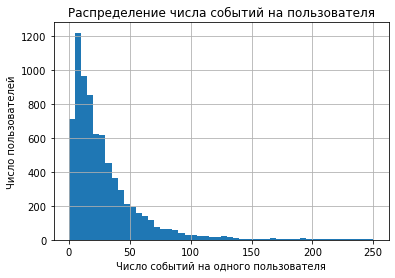

In [14]:
event_user.hist(bins=50, range=(0, 250))
plt.title('Распределение числа событий на пользователя')
plt.xlabel('Число событий на одного пользователя')
plt.ylabel('Число пользователей')
plt.show()

На графике видно, что есть участники с аномально большим количеством событий. Найдем число с помощью моды

In [15]:
event_user.mode()

0    5
Name: event_name, dtype: int64

Выводы:
- Среднее: 32
- Медиана: 20
- Мода: 5

По графику видно, что рациональнее при такой ситуации использовать медиану, а не среднее

**Максимальная и минимальная даты**

In [24]:
last_day = df['date'].max()
first_day = (df['date'].min())
print(f'Данные представлены с {first_day} до {last_day}.')
print(f'Всего таблице - {(last_day - first_day).days} дней.')

Данные представлены с 2019-07-25 00:00:00 до 2019-08-07 00:00:00.
Всего таблице - 13 дней.


In [26]:
# построение гистограммы по дате и времени
#fig = px.histogram(df, x='date',labels={'date':'', 'event_name':'Название события'},color="event_name",log_y=True,)
#fig.update_yaxes(tickfont=dict(size=20))
#fig.update_layout(title_text= 'Распределение количества событий по дням',font=dict(family="Rockwell",size=15, color="black"))
#fig.update_layout(bargap=0.2)
#fig.update_xaxes(title='День')
#fig.update_yaxes(title='Количество')
#fig.show()

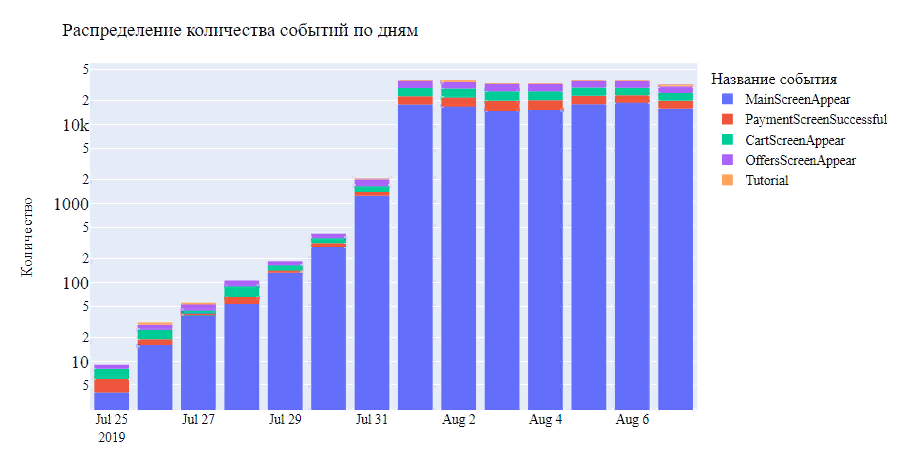

На гистограмме видно, что данные до 1 августа 2019 года частично отсутствуют.  На самом деле мы располагаем данными с 1 августа. У нас есть данные за целую неделю, это хорошо

**Посчитаем сколько событий и пользователей мы потеряли, отбросив старые данные**

In [28]:
data = df.query('date >= "2019-08-01"')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   even_time   240887 non-null  datetime64[ns]
 3   group       240887 non-null  int64         
 4   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [29]:
user= df["user_id"].nunique() - data["user_id"].nunique()
print('Мы потеряли', user , 'пользователей.')

Мы потеряли 17 пользователей.


In [30]:
event= df["event_name"].count() - data["event_name"].count()
print('Мы потеряли',event, 'событий.')

Мы потеряли 2826 событий.


In [31]:
print('Количество потерянных пользователей - ', round(user/df["user_id"].nunique()*100,2) , '% от первоначального количества ')
print(f'Количество потерянных событий ', round(event/df["event_name"].count()*100,2), '% от первоначального количества ')

Количество потерянных пользователей -  0.23 % от первоначального количества 
Количество потерянных событий  1.16 % от первоначального количества 


Из 7551 пользователей мы потеряли 0.23% -  это очень незначительное число. И 1.16 % Из событий от первоначального количества.

**Проверка наличия пользователей из всех трёх экспериментальных групп**

In [32]:
data.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Да, все три группы есть в данных

Вывод:
- Данные в первоначальной таблице представлены за 13 дней с 2019-07-25 до 2019-08-07;
- При построении графика видно, что существует перекос в датах до 1 августа представлены не все данные;
- Оставили данные после 1 августа для исправления перекоса. Было удалено 0.23% пользователей и 1.16 % событий;
- В нашей таблице присутствуют все группы пользователей, после корректировки данных.

<a id='Изучение воронки событий'></a>
## Изучение воронки событий

**События в логах**

In [33]:
# события в логах, как часто встречаются и сортировка по частоте
data_sort= data.groupby(['event_name'])['user_id'].count().reset_index()
data_sort = data_sort.sort_values(['user_id'], ascending=False)
data_sort

,event_name,user_id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [37]:
#график распределения действий пользователей по их количеству
#fig = go.Figure()
#pull = [0]*len(data_sort['user_id'])
#pull[data_sort['event_name'].tolist().index(data_sort['event_name'].max())] = 0.1
#fig.add_trace(go.Pie(values=data_sort['user_id'], labels= data_sort['event_name'], pull=pull))
#fig.update_layout(title="Распределение действий пользователей по их количеству", legend_orientation="h")
#fig.show()

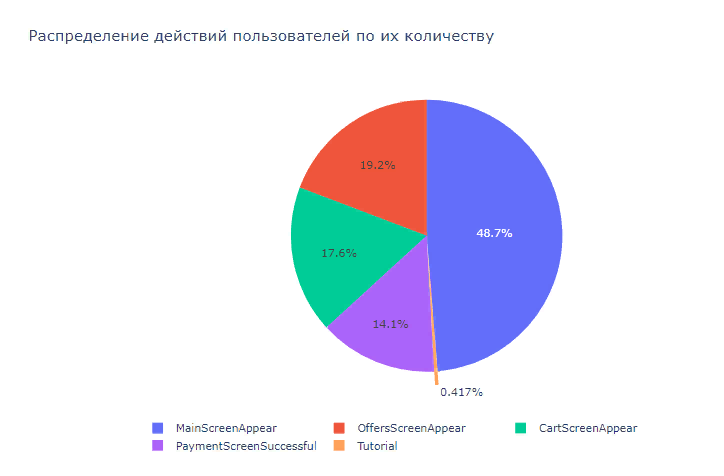

События MainScreenAppear больше всего - 117328. Событие Tutorial в данный продуктовой воронке мало - 1005.

**Количество пользователей, совершивших каждое из этих событий и доли пользователей, которые хоть раз совершали событие**

In [38]:
# количество пользователей, совершивших каждое из этих событий
data_user = data.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
data_user.columns = ['event_count', 'user_id']
data_user = data_user.reset_index()
# доля пользователей, хоть раз совершивших событие
data_user['%'] = (data_user['user_id'] / all_user * 100).round(1) # доля хотя бы раз совершивших событие
data_user 

,event_name,event_count,user_id,%
0,MainScreenAppear,117328,7419,98.3
1,OffersScreenAppear,46333,4593,60.8
2,CartScreenAppear,42303,3734,49.5
3,PaymentScreenSuccessful,33918,3539,46.9
4,Tutorial,1005,840,11.1


In [40]:
# построение графика воронки
#fig = go.Figure(go.Funnel(y = data_user["event_name"], x = data_user["user_id"],textposition = "inside", textinfo = "value+percent previous", marker = {"color": "royalblue"}))
#fig.update_layout(title='Распределение количества пользователей по их действиям',showlegend=False,height=500, width=1000)
#fig.show()

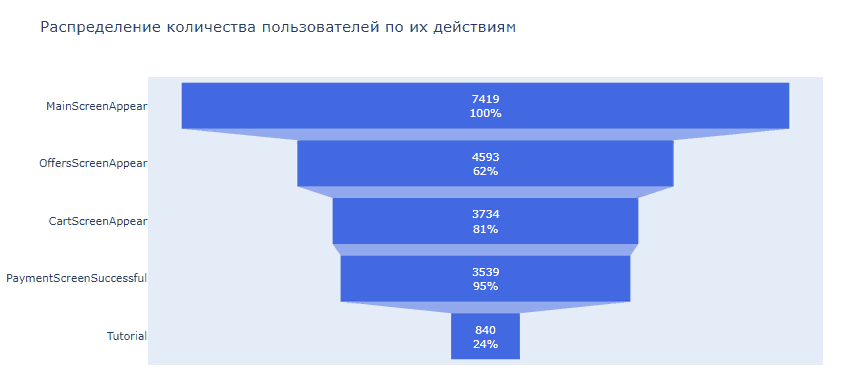

In [41]:
# Посчитаем конверсию в группах 
df_group1 = data.pivot_table(index='event_name', values='user_id', columns='group',aggfunc=lambda x: len(x.unique()))
df_group1 = df_group1.reset_index().sort_values(by=246, ascending=False)
df_group1

group,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [44]:
# построение графика воронки по группам
#fig = go.Figure()
#fig.add_trace(go.Funnel(name = '246 группа (А1)',
    #y = df_group1["event_name"],
    #x = df_group1[246],textposition = "inside", 
    #textinfo = "value+percent previous",))

#fig.add_trace(go.Funnel(name = '248 группа (В)',
    #y = df_group1["event_name"],
    #x = df_group1[248],textposition = "inside", 
    #textinfo = "value+percent previous"))

#fig.add_trace(go.Funnel(name = '247 группа (А2)',
    #y = df_group1["event_name"],
    #x = df_group1[247],textposition = "inside", 
    #textinfo = "value+percent previous"))
#fig.update_layout(title='Распределение количества пользователей по их действиям в группах',height=500, width=800)
#fig.show()

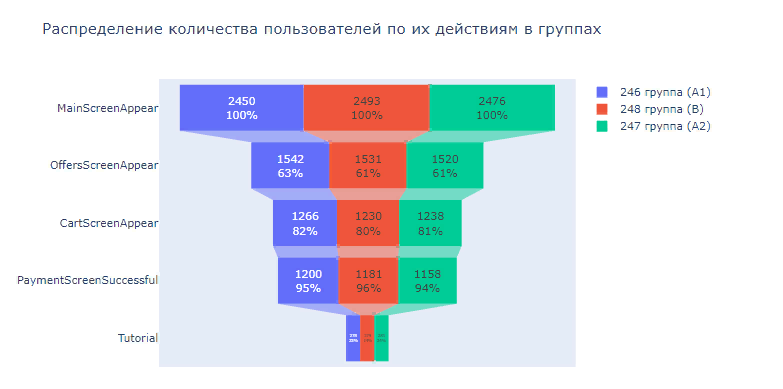

7419 пользователей заходили на главный экран мобильного приложения (MainScreenAppear). 3539 пользователей дошли до оплаты (PaymentScreenSuccessful).Показатели не вызывают подозрений

**Рассмотрим в каком порядке происходят события**


- сначала открывают главный экран приложения(MainScreenAppear)
- потом  выбирает товар(ы) (OffersScreenAppear) 
- кладёт товар(ы) в корзину (CartScreenAppear)
- оплачивает (PaymentScreenSuccessful).

Не все события выстраиваются в последовательную цепочку. Изучение руководства пользователя(Tutorial) используют всего 840 пользователей, и оно выбивается из цепочки. На следующем этапе уберем это событие

**Расчет доли пользователей которые проходят на следующий шаг воронки**

In [45]:
data1=data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
data1

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

In [46]:
print('С главного экрана в каталог товаров перешло', round(data1['OffersScreenAppear']/data1['MainScreenAppear'] *100, 2) , '% клиентов.')
print(f'С каталога товаров в корзину перешло', round(data1['CartScreenAppear']/data1['OffersScreenAppear'] *100, 2) ,'% клиентов.')
print(f'С корзины до экрана успешной оплаты перешло', round(data1['PaymentScreenSuccessful']/data1['CartScreenAppear'] *100, 2), '% клиентов.')

С главного экрана в каталог товаров перешло 61.91 % клиентов.
С каталога товаров в корзину перешло 81.3 % клиентов.
С корзины до экрана успешной оплаты перешло 94.78 % клиентов.


**На каком шаге теряем больше всего пользователей**

In [47]:
print(100 - round(data1['OffersScreenAppear']/data1['MainScreenAppear'] *100, 2))

38.09


При переходе с главного экрана в корзину товаров теряется больше всего пользователей. Вероятно, нужно лучше прорабатывать механику, чтобы пользователи переходили к OffersScreen

**Доля пользователей которая доходит от первого события до оплаты?**

In [48]:
print(round(data1['PaymentScreenSuccessful']/data1['MainScreenAppear'] *100, 2))

47.7


Доля пользователей доходит от первого события до оплаты - 47.7 % клиентов.

Выводы: 
- Быта предположена воронка: сначала открывают главный экран приложения(MainScreenAppear)- потом выбирает товар(ы) (OffersScreenAppear)- кладёт товар(ы) в корзину (CartScreenAppear)- оплачивает (PaymentScreenSuccessful).
- Не все события выстраиваются в последовательную цепочку. Изучение руководства пользователя(Tutorial) используют всего 840 пользователей, и оно выбивается из цепочки. Убрали это событие
- При переходе с главного экрана в корзину товаров теряется больше всего пользователей. Нужно рассмотреть данное звено подробнее и выявить проблему
- Доля пользователей доходит от первого события до оплаты - 47.7 % клиентов. Это хороший показатель 

<a id='Изучение результатов эксперимента'></a>
## Изучение результатов эксперимента

**Количество пользователей в каждой экспериментальной группе**

При изучении результатов А/В теста лучше убедиться, что у нас нет пользователей, которые участвовали в двух или более группах одновременно

In [49]:
df3= data.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()
df3

group    0
dtype: int64

Одинаковых пользователей в двух и более группах нет. Посчитаем сколько пользователей в каждой экспериментальной группе

In [50]:
users_count = data.groupby('group')['user_id'].nunique()
users_count

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

**Проверка наличия разницы, с помощью статистических критериев, между выборками 246 и 247 (2 контрольные группы для А/А-эксперимента)**

In [51]:
df_group = data.pivot_table(index='event_name', values='user_id', columns='group',aggfunc=lambda x: len(x.unique()))
df_group = df_group.reset_index().sort_values(by=246, ascending=False)
df_group = df_group[df_group['event_name'] != 'Tutorial']
df_group

group,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


246-я и 247-я группы контрольные (А-А)

248-я группа - тестируемая (В)

Составим функцию которая позволит нам проверять статистическую разницу между выборками A-A (246-247).Применим поправку Бонферрони - поделим альфа на количество гипотиз.

Обозначу нулевую и альтернативную гипотезы, а также примем alpha=0.05
- Н0 - доли уникальных посетителей,  побывавших на этапе воронки, в группах 246 и 247 одинаковы; 
- Н1 - между долями уникальных посетителей, побывавших на этапе воронки, в группах 246 и 247 различие есть. 

In [52]:
def AA_test(purchasesA ,purchasesB ,leadsA ,leadsB , eventname, alpha = 0.05/12):
    # пропорция успехов в первой группе:
    p1 = purchasesA/leadsA
    # пропорция успехов во второй группе:
    p2 = purchasesB/leadsB
    # пропорция успехов в комбинированном датасете:
    p_combined = (purchasesA + purchasesB) / (leadsA + leadsB)
    # разница пропорций в датасетах
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leadsA + 1/leadsB))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value =(1 - distr.cdf(abs(z_value))) * 2
    print(f'Расчет теста для действия пользователей {eventname}')
    print('p-значение: ', p_value)

    if p_value < alpha:

        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print(' ')

In [53]:
test_A1B = [AA_test(df_group[246][i],df_group[247][i],users_count[246],
                    users_count[247],df_group['event_name'][i], alpha =  0.05/12) for i in range(len(df_group[246]))]

Расчет теста для действия пользователей CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


По результатам A/A тестирования для всех событий разница не оказалось значимой, поэтому эти группы считаем контрольными. Можем приступить к АВ тестированию

**Cамое популярное событие и проверка корректности разбиения на группы**

In [54]:
data_test = data[data['event_name']!='Tutorial'].pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by=246, ascending=False)
data_test= data_test.reset_index()
#Посчитаем число пользователей, совершивших  событие в каждой из контрольных групп
data_test['246+247'] = data_test[246] + data_test[247]
data_test['all'] = data_test['246+247'] + data_test[248]

# Посчитаем долю пользователей, совершивших это событие.
data_test['246-%'] = (data_test[246] / users_count[246]*100).round(1)
data_test['247-%'] = (data_test[247] / users_count[247] * 100).round(1)
data_test['248-%'] = (data_test[248] / users_count[248] * 100).round(1)
data_test['246+247-%'] = (data_test['246+247'] / (users_count[246]+ users_count[247])*100).round(1)

data_test

group,event_name,246,247,248,246+247,all,246-%,247-%,248-%,246+247-%
0,MainScreenAppear,2450,2476,2493,4926,7419,98.6,98.5,98.3,98.6
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.3,61.3
2,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.2


Здесь как раз мы видим доли в каждой группе, разница между группами на каждом этапе небольшая. Вот эту разницу, а точнее ее значимость проверяем z-критерием.

In [55]:
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [57]:
# график  Распределение количества пользователей по этапам в руппах 247 и 246
#fig = go.Figure()
#fig.add_trace(go.Funnel(name = '246 группа',
    #y = df_group["event_name"],
    #x = df_group[246],textposition = "inside", 
    #textinfo = "value+percent previous",
    #marker = {"color": "royalblue"}))

#fig.add_trace(go.Funnel(name = '247 группа',
    #y = df_group["event_name"],
    #x = df_group[247],textposition = "inside", 
    #textinfo = "value+percent previous",
    #marker = {"color": "pink"}))
#fig.update_layout(title='Распределение количества пользователей по этапам в руппах 247 и 246',height=400, width=800)
#fig.show()

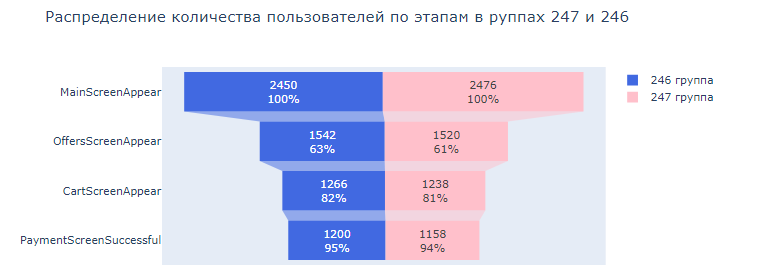

Cамое популярное событие - MainScreenAppear - 7423, в разрезе групп:

246 группа- 2450

247 группа - 2476

248 группа - 2493

Доли пользователей совершивших самое популярное событие "MainScreenAppear":

246 группа- 98,6%

247 группа - 98,5%

248 группа - 98,3%

Да разбиение на группы работает корректно, воронка постепенно уменьшается и цепочка последовательности не нарушена

**Сравнение результатов группы с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.**

Гипотезы:
- Н0 - доли уникальных посетителей,  побывавших на этапе воронки, в группах 246 и 248 одинаковы; 
- Н1 - между долями уникальных посетителей, побывавших на этапе воронки, в группах 246 и 248 различие есть. 

In [58]:
test_A1B = [AA_test(df_group[246][i],df_group[248][i],users_count[246],users_count[248],
                    df_group['event_name'][i], alpha =  0.05/12) for i in range(len(df_group[248]))]

Расчет теста для действия пользователей CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


Между группами 248 и 246 нет различий.

Гипотезы:
- Н0 - доли уникальных посетителей,  побывавших на этапе воронки, в группах 246 и 247 одинаковы; 
- Н1 - между долями уникальных посетителей, побывавших на этапе воронки, в группах 246 и 247 различие есть. 

In [59]:
test_A2B = [AA_test(df_group[247][i],df_group[248][i], users_count[247],
                    users_count[248],df_group['event_name'][i], alpha =  0.05/12) for i in range(len(df_group[248]))]

Расчет теста для действия пользователей CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


Между группами 248 и 247  нет большой разницы.

Гипотезы:
- Н0 - В значениях групп 248 и 247+246 различие между группами нет; 
- Н1 - В значениях групп 248 и 247+246 различие есть. 

In [60]:
test_AAB = [AA_test(df_group[246][i]+df_group[247][i], df_group[248][i], (users_count[246]+users_count[247]) ,
                    users_count[248], df_group['event_name'][i], alpha =  0.05/12) for i in range(len(df_group[248]))]

Расчет теста для действия пользователей CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


Значимой разницы между группами во всех тестах не выявлено.

**Рассмотрим гипотезы при уровне значимости 0.1**

In [61]:
def AB_test(purchases246 ,purchases247 ,leads246 ,leads247 , eventname, alpha = 0.1/12):
    # пропорция успехов в первой группе:
    p1 = purchases246/leads246
    # пропорция успехов во второй группе:
    p2 = purchases247/leads247
    # пропорция успехов в комбинированном датасете:
    p_combined = (purchases246 + purchases247) / (leads246 + leads247)
    # разница пропорций в датасетах
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads246 + 1/leads247))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value =(1 - distr.cdf(abs(z_value))) * 2
    print(f'Расчет теста для действия пользователей {eventname}')
    print('p-значение: ', p_value)

    if p_value < alpha:

        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print(' ')

In [62]:
test_12 = [AB_test(df_group[246][i],df_group[247][i],df_group[246].sum(), df_group[247].sum(),df_group['event_name'][i], 
                  alpha =  0.1/12) for i in range(len(df_group[246]))]

Расчет теста для действия пользователей CartScreenAppear
p-значение:  0.7359876852552283
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей MainScreenAppear
p-значение:  0.35195027387494493
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей OffersScreenAppear
p-значение:  0.8966517949162409
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей PaymentScreenSuccessful
p-значение:  0.4957537491808677
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


Так как группы 246/247 (А/А) должны быть одинаковыми, то над ними и контроль жестче. Поэтому для проведения A/A тестирования был взят уровень статистической значимости равный 1%. По результатам A1/A2 тестирования для всех событий разница не оказалось значимой, поэтому эти группы считаем контрольными.

A-246 и В-248

In [63]:
test_A1B = [AB_test(df_group[248][i],df_group[246][i],df_group[248].sum(),
                    df_group[246].sum(),df_group['event_name'][i], alpha =  0.1/12) for i in range(len(df_group[248]))]

Расчет теста для действия пользователей CartScreenAppear
p-значение:  0.4819458398461809
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей MainScreenAppear
p-значение:  0.3479384267818224
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей OffersScreenAppear
p-значение:  0.9091919819522383
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей PaymentScreenSuccessful
p-значение:  0.7377553009873645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


A-247 и В-248

In [64]:
test_A2B = [AB_test(df_group[248][i],df_group[247][i],df_group[248].sum(),
                    df_group[247].sum(),df_group['event_name'][i], alpha =  0.1/12) for i in range(len(df_group[248]))]

Расчет теста для действия пользователей CartScreenAppear
p-значение:  0.7154743061042801
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей MainScreenAppear
p-значение:  0.9950483608560174
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей OffersScreenAppear
p-значение:  0.9872247229217914
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей PaymentScreenSuccessful
p-значение:  0.7288652017205819
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


А 247+246 И В-248

In [65]:
test_AAB = [AB_test(df_group[248][i],df_group[246][i]+df_group[247][i],df_group[248].sum(),
                    (df_group[246]+df_group[247]).sum(),df_group['event_name'][i], alpha =  0.1/12) for i in range(len(df_group[248]))]

Расчет теста для действия пользователей CartScreenAppear
p-значение:  0.5374067036534838
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей MainScreenAppear
p-значение:  0.584187313263467
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей OffersScreenAppear
p-значение:  0.9546052060788499
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Расчет теста для действия пользователей PaymentScreenSuccessful
p-значение:  0.9965395455405515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


<a id='Вывод'></a>
## Вывод

При изучении данных, выявлено:
- данные представлены за период с 25 июля по 7 августа 2019 года. Полные данные представлены только за период с 1 по 7 августа. Сформирован вывод, что это было либо тестирование, либо неверные данные. Поэтому июльские данные принято исключить из анализа и оставить только период с августа.
- Из 7551 пользователей мы потеряли 0.23% - это очень незначительное число. И 1.16 % Из событий от первоначального количества.
- Воронка продаж. 
- MainScreenAppear - Появление Главного экрана - самое популярное событие.  Число пользователей, совершивших событие - 7419, примерно по 2,5 тысячи на группу. Доли пользователей, совершивших самое популярное событие - 98,5%.
- Была предложена воронка: сначала открывают главный экран приложения(MainScreenAppear)- потом выбирает товар(ы) (OffersScreenAppear)- кладёт товар(ы) в корзину (CartScreenAppear)- оплачивает (PaymentScreenSuccessful).
- Не все события выстраиваются в последовательную цепочку. Изучение руководства пользователя(Tutorial) используют всего 840 пользователей, и оно выбивается из цепочки. Tutorial в дальнейшем исключен из воронки;
- При переходе с главного экрана в корзину товаров теряется больше всего пользователей. Нужно рассмотреть данное звено подробнее и выявить проблему
- Пройдя по воронке, до PaymentScreenSuccessful пользователей доходит от первого события до оплаты - 47.7 % клиентов. Это хороший показатель


В ходе тестирования были проведены 16 экспериментов:

A1/A1 - 4 эксперемента (для каждого события) / уровень статистической значимости - 1%

A1/B - 4 эксперемента (для каждого события) / уровень статистической значимости - 5%

A2/B - 4 эксперемента (для каждого события) / уровень статистической значимости - 5%

A1+A2/B - 4 эксперемента (для каждого события) / уровень статистической значимости - 5%
- Для проведения A/A тестирования был взят уровень статистической значимости равный 1%. По результатам A1/A2 тестирования для всех событий разница не оказалось значимой, поэтому эти группы считаем контрольными. - Уровень статистической значимости в 10% был бы слишком велик так как в тесте не ожидаем изменений не менее чем 30% (в таком случае 10% погрешности измерений нас бы устроила). 
- В результате всех A/A/B эксперементов значимой разницы между группами не выявлено. Поэтому можно утверждать, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Тестирование можно назвать успешным - изменение шрифта не повлияло на поведение пользователей, но и не сделало лучше. Нужно искать другие пути решения